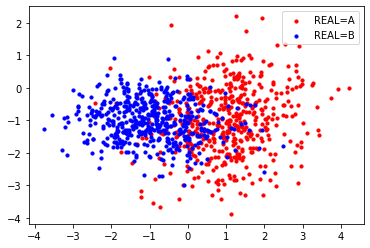

In [79]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

n_samples = 1000
X, y = make_classification(n_samples=n_samples, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0, 
                           n_classes=2, n_clusters_per_class=1, 
                           random_state=92)
y = y * 2 - 1 # (y = 0 or 1) => (y = -1 or 1)
X_train, X_test = np.split(X, (n_samples * 8 // 10, ))
y_train, y_test = np.split(y, (n_samples * 8 // 10, ))

plt.scatter(X[y > 0, 0], X[y > 0, 1], c = 'red', s=10, label='REAL=A')
plt.scatter(X[y < 0, 0], X[y < 0, 1], c = 'blue', s=10, label='REAL=B')
plt.legend()
plt.show()

In [80]:
import numpy as np
from cvxopt import matrix
from cvxopt.solvers import qp


class SVM(object):
    def __init__(self, kernel):
        self.kernel, self.kernel_name = kernel
        self.alpha_sv = None
        self.b = None
        self.X_sv = None
        self.y_sv = None
    
    def _kernel_matrix(self, X):
        n_samples = X.shape[0]
        km = np.zeros((n_samples, n_samples), dtype=float)
        for i in range(n_samples):
            for j in range(n_samples):
                km[i, j] = self.kernel(X[i], X[j])
        return km
    
    def train(self, X, y, C=1, Epsilon=1e-5):
        n_samples = X.shape[0]
        
        P = matrix(np.outer(y, y) * self._kernel_matrix(X))
        q = matrix(-np.ones(n_samples))
        G = matrix(np.concatenate((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.concatenate((np.zeros(n_samples), np.ones(n_samples) * C)))
        A = matrix(y.astype('double'), size=(1, n_samples))
        b = matrix(0.0)
        sol = qp(P, q, G, h, A, b)
        
        alpha = np.ravel(sol['x'])
        sv = alpha > Epsilon
        self.alpha_sv, self.X_sv, self.y_sv = alpha[sv], X[sv], y[sv]
        self.b = 0
        
        s = 0
        for i in range(len(self.alpha_sv)):
            if self.alpha_sv[i] > C - Epsilon:
                continue
            s += 1
            self.b += 1 / self.y_sv[i]
            for j in range(len(self.alpha_sv)):
                self.b -= self.alpha_sv[j] * self.y_sv[j] * self.kernel(self.X_sv[j], self.X_sv[i])
        self.b /= s
        return self.alpha_sv, self.b, self.X_sv, self.y_sv
    
    def test(self, X, y):
        n_samples = X.shape[0]
        
        y_pred = np.ones_like(y) * self.b
        for i in range(n_samples):
            for j in range(len(self.alpha_sv)):
                y_pred[i] += self.alpha_sv[j] * self.y_sv[j] * self.kernel(self.X_sv[j], X[i])
        y_pred = np.sign(y_pred).astype('int32')
        accuracy = np.sum(y_pred == y) / n_samples
        print("Test accuracy %.4f%%" % (accuracy * 100))
        
        AA = np.logical_and(y > 0, y_pred > 0)
        AB = np.logical_and(y > 0, y_pred < 0)
        BA = np.logical_and(y < 0, y_pred > 0)
        BB = np.logical_and(y < 0, y_pred < 0)
        plt.scatter(X[AA, 0], X[AA, 1], c = 'red', s=10, label='REAL=A, PRED=A')
        plt.scatter(X[AB, 0], X[AB, 1], c = 'green', s=10, label='REAL=A, PRED=B')
        plt.scatter(X[BA, 0], X[BA, 1], c = 'black', s=10, label='REAL=B, PRED=A')
        plt.scatter(X[BB, 0], X[BB, 1], c = 'blue', s=10, label='REAL=B, PRED=B')
        plt.title('SVM with %s kernel' % self.kernel_name)
        plt.legend()
        plt.show()
        return y_pred

     pcost       dcost       gap    pres   dres
 0: -4.1681e+02 -2.1832e+03  1e+04  3e+00  3e-14
 1: -2.7886e+02 -1.5033e+03  2e+03  4e-01  2e-14
 2: -2.5712e+02 -4.4287e+02  2e+02  6e-03  2e-14
 3: -3.0022e+02 -3.4961e+02  5e+01  1e-03  1e-14
 4: -3.0688e+02 -3.4206e+02  4e+01  9e-04  1e-14
 5: -3.1144e+02 -3.3609e+02  3e+01  5e-04  1e-14
 6: -3.1484e+02 -3.3182e+02  2e+01  3e-04  1e-14
 7: -3.1754e+02 -3.2837e+02  1e+01  2e-04  1e-14
 8: -3.1824e+02 -3.2752e+02  9e+00  1e-04  1e-14
 9: -3.1924e+02 -3.2610e+02  7e+00  7e-05  1e-14
10: -3.2053e+02 -3.2454e+02  4e+00  3e-05  1e-14
11: -3.2133e+02 -3.2361e+02  2e+00  1e-05  1e-14
12: -3.2174e+02 -3.2311e+02  1e+00  6e-06  1e-14
13: -3.2231e+02 -3.2247e+02  2e-01  4e-15  2e-14
14: -3.2239e+02 -3.2239e+02  4e-03  4e-15  2e-14
15: -3.2239e+02 -3.2239e+02  1e-04  2e-14  2e-14
Optimal solution found.
Test accuracy 86.0000%


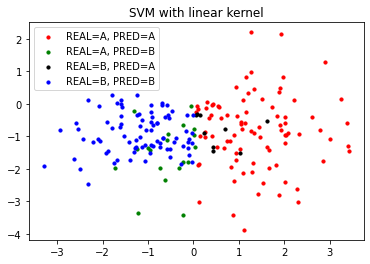

In [81]:
def linear_kernel():
    def _kernel(x_i, x_j):
        return x_i @ x_j
    return _kernel, 'linear'

svm = SVM(linear_kernel())
_ = svm.train(X_train, y_train)
_ = svm.test(X_test, y_test)

     pcost       dcost       gap    pres   dres
 0: -3.5053e+02 -1.9576e+03  9e+03  3e+00  4e-15
 1: -2.2796e+02 -1.2318e+03  1e+03  1e-01  3e-15
 2: -2.4264e+02 -3.9606e+02  2e+02  2e-02  3e-15
 3: -2.6658e+02 -3.1348e+02  5e+01  4e-03  2e-15
 4: -2.7365e+02 -2.9291e+02  2e+01  1e-03  2e-15
 5: -2.7656e+02 -2.8591e+02  9e+00  5e-04  2e-15
 6: -2.7809e+02 -2.8285e+02  5e+00  2e-04  2e-15
 7: -2.7897e+02 -2.8121e+02  2e+00  6e-05  3e-15
 8: -2.7940e+02 -2.8046e+02  1e+00  2e-05  3e-15
 9: -2.7958e+02 -2.8017e+02  6e-01  7e-06  2e-15
10: -2.7973e+02 -2.7995e+02  2e-01  2e-06  3e-15
11: -2.7978e+02 -2.7988e+02  1e-01  4e-07  3e-15
12: -2.7982e+02 -2.7983e+02  1e-02  3e-08  3e-15
13: -2.7982e+02 -2.7983e+02  3e-03  5e-09  3e-15
14: -2.7983e+02 -2.7983e+02  1e-04  1e-10  3e-15
Optimal solution found.
Test accuracy 86.0000%


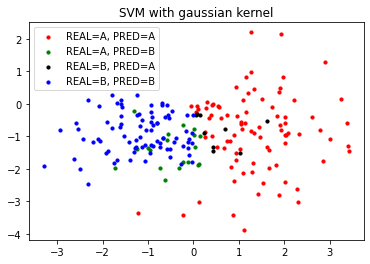

In [82]:
def gaussian_kernel(sigma=1):
    def _kernel(x_i, x_j):
        return np.exp(-np.linalg.norm(x_i - x_j) ** 2 / (2 * sigma ** 2))
    return _kernel, 'gaussian'

svm = SVM(gaussian_kernel())
_ = svm.train(X_train, y_train)
_ = svm.test(X_test, y_test)

     pcost       dcost       gap    pres   dres
 0: -3.9961e+02 -2.1661e+03  1e+04  3e+00  2e-13
 1: -2.6967e+02 -1.4823e+03  2e+03  4e-01  1e-13
 2: -2.4301e+02 -5.3334e+02  3e+02  4e-02  8e-14
 3: -2.7408e+02 -3.5075e+02  8e+01  8e-03  7e-14
 4: -2.8830e+02 -3.2562e+02  4e+01  3e-03  8e-14
 5: -2.9381e+02 -3.1612e+02  2e+01  2e-03  8e-14
 6: -2.9723e+02 -3.1050e+02  1e+01  8e-04  7e-14
 7: -2.9953e+02 -3.0690e+02  8e+00  4e-04  7e-14
 8: -3.0141e+02 -3.0409e+02  3e+00  1e-04  8e-14
 9: -3.0191e+02 -3.0333e+02  1e+00  5e-05  8e-14
10: -3.0236e+02 -3.0273e+02  4e-01  9e-06  9e-14
11: -3.0248e+02 -3.0258e+02  9e-02  1e-06  8e-14
12: -3.0251e+02 -3.0254e+02  3e-02  4e-07  9e-14
13: -3.0252e+02 -3.0253e+02  1e-02  3e-08  8e-14
14: -3.0253e+02 -3.0253e+02  4e-03  7e-09  8e-14
15: -3.0253e+02 -3.0253e+02  6e-05  9e-11  8e-14
Optimal solution found.
Test accuracy 86.5000%


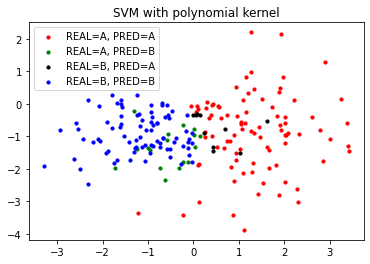

In [83]:
def laplacian_kernel(sigma=1):
    def _kernel(x_i, x_j):
        return np.exp(-np.linalg.norm(x_i - x_j) / sigma)
    return _kernel, 'laplacian'

svm = SVM(polynomial_kernel())
_ = svm.train(X_train, y_train)
_ = svm.test(X_test, y_test)